In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

import pytorch_spiking

torch.manual_seed(0)
np.random.seed(0)

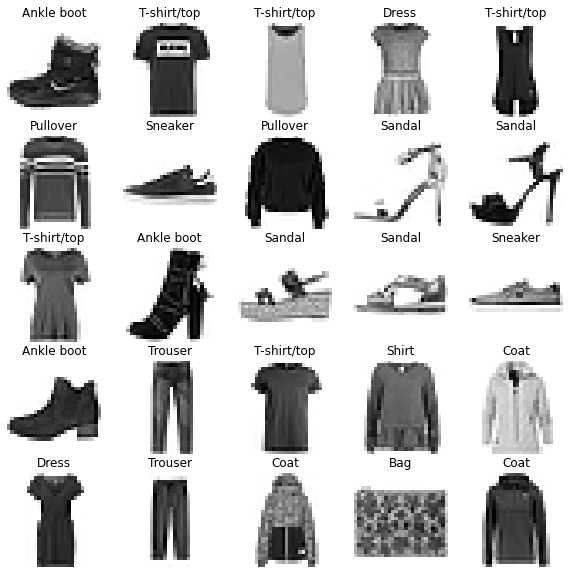

In [2]:
train_images, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
test_images, test_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=False, download=True)
)
test_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
test_labels = np.asarray(train_labels, dtype=np.int64)

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

In [3]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)


def train(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adam(input_model.parameters())

    input_model.train()
    for j in range(10):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_model.zero_grad()

            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_model(torch.tensor(batch_in))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()

            loss.backward()
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print("Train accuracy (%d): " % j, train_acc.numpy())

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1

    print("Test accuracy:", test_acc.numpy())


train(model, train_images, test_images)

Train accuracy (0):  0.81866664
Train accuracy (1):  0.8623
Train accuracy (2):  0.87555
Train accuracy (3):  0.88388336
Train accuracy (4):  0.89
Train accuracy (5):  0.89526665
Train accuracy (6):  0.9009167
Train accuracy (7):  0.90465
Train accuracy (8):  0.9073333
Train accuracy (9):  0.91068333
Test accuracy: 0.90858334


In [4]:
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

In [5]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model, train_sequences, test_sequences)

Train accuracy (0):  0.81916666
Train accuracy (1):  0.86253333
Train accuracy (2):  0.87528336
Train accuracy (3):  0.88348335
Train accuracy (4):  0.8889667
Train accuracy (5):  0.8948
Train accuracy (6):  0.89916664
Train accuracy (7):  0.90385
Train accuracy (8):  0.90751666
Train accuracy (9):  0.90996665
Test accuracy: 0.17736667


In [6]:
def check_output(seq_model, modify_dt=None):  # noqa: C901
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model in a form that will let us access the output of
    # intermediate layers
    class Model(torch.nn.Module):
        def __init__(self):
            super().__init__()

            self.has_temporal_pooling = False
            for i, module in enumerate(seq_model.modules()):
                if isinstance(module, pytorch_spiking.TemporalAvgPool):
                    # remove the pooling so that we can see the model's output over time
                    self.has_temporal_pooling = True
                    continue

                if isinstance(
                    module, (pytorch_spiking.SpikingActivation, pytorch_spiking.Lowpass)
                ):
                    # update dt, if specified
                    if modify_dt is not None:
                        module.dt = modify_dt
                    # always return the full time series so we can visualize it
                    module.return_sequences = True

                if isinstance(module, pytorch_spiking.SpikingActivation):
                    # save this layer so we can access it later
                    self.spike_layer = module

                if i > 0:
                    self.add_module(str(i), module)

        def forward(self, inputs):
            x = inputs

            for i, module in enumerate(self.modules()):
                if i > 0:
                    x = module(x)

                    if isinstance(module, pytorch_spiking.SpikingActivation):
                        # save this layer so we can access it later
                        spike_output = x

            return x, spike_output

    func_model = Model()

    # run model
    func_model.eval()
    with torch.no_grad():
        output, spikes = func_model(
            torch.tensor(
                test_sequences.reshape(
                    test_sequences.shape[0], test_sequences.shape[1], -1
                )
            )
        )
    output = output.numpy()
    spikes = spikes.numpy()

    if func_model.has_temporal_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * func_model.spike_layer.dt
    n_spikes = spikes * func_model.spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * func_model.spike_layer.dt,
            torch.softmax(torch.tensor(output[ii]), dim=-1),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Test accuracy: 18.10%
Spike rate per neuron (Hz): min=0.00 mean=0.66 max=100.00


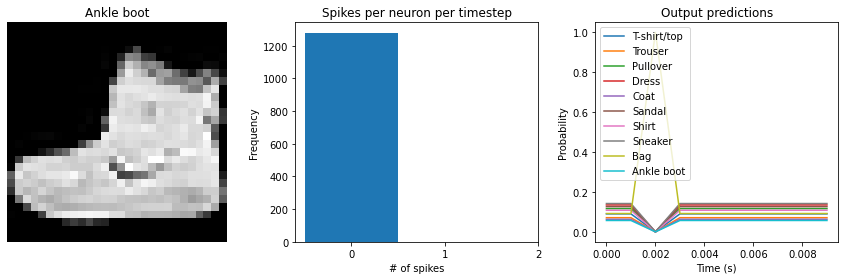

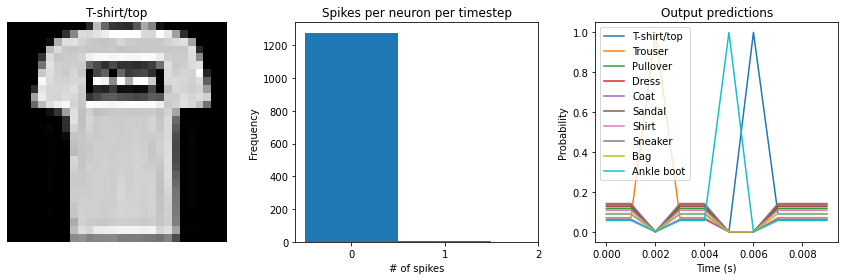

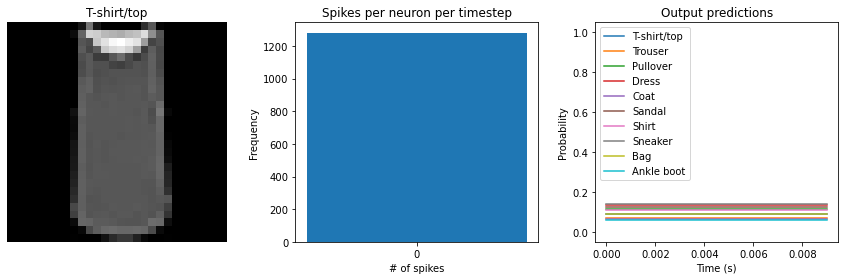

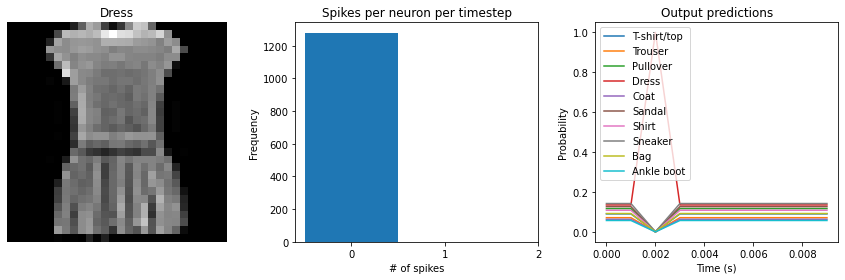

In [7]:
check_output(spiking_model)

Test accuracy: 64.55%
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=30.00


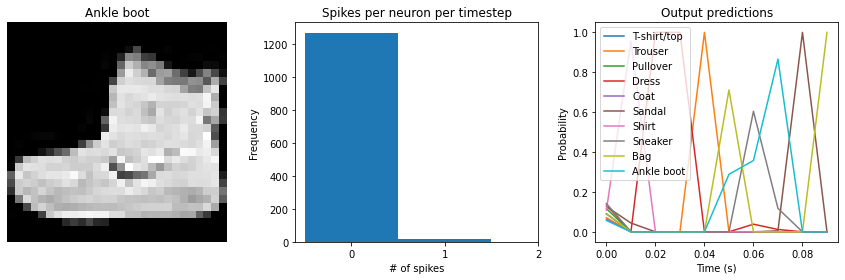

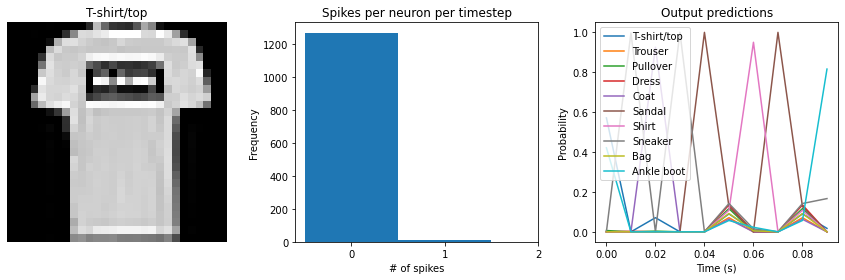

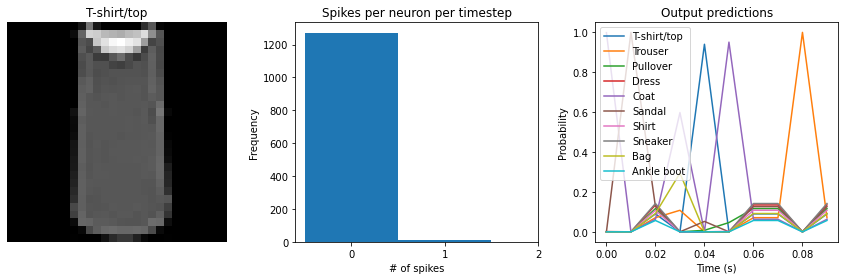

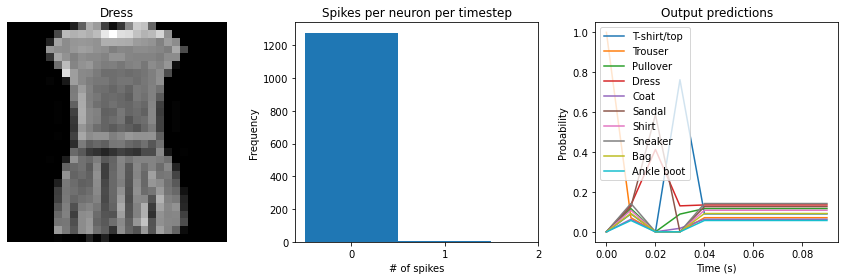

In [8]:
# dt=0.01 * 10 timesteps is equivalent to 0.1s of simulated time
check_output(spiking_model, modify_dt=0.01)

Test accuracy: 90.00%
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=25.00


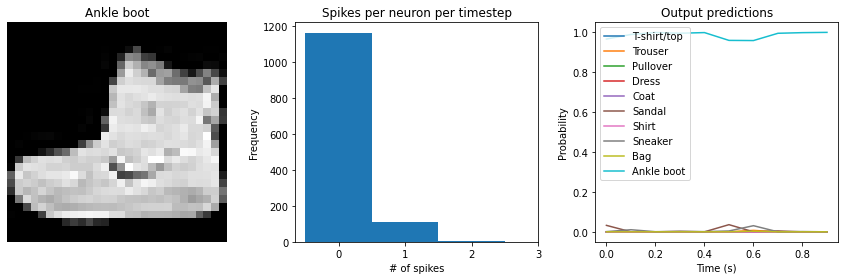

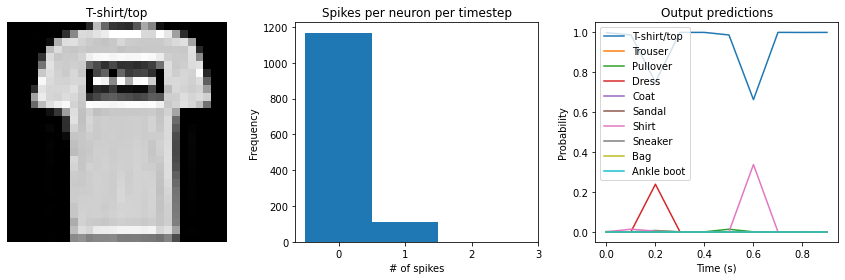

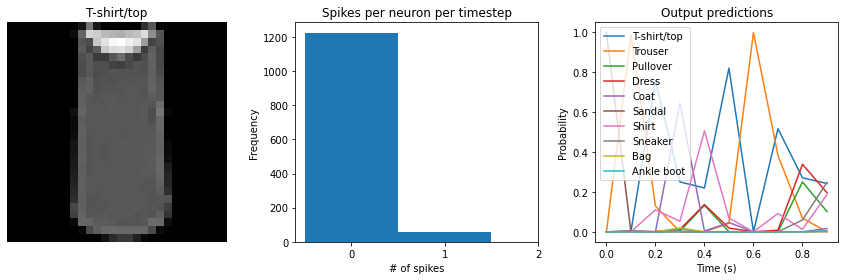

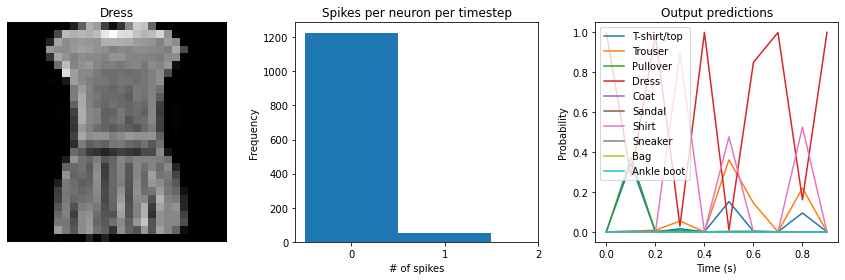

In [9]:
check_output(spiking_model, modify_dt=0.1)

Test accuracy: 90.48%
Spike rate per neuron (Hz): min=0.00 mean=0.65 max=25.10


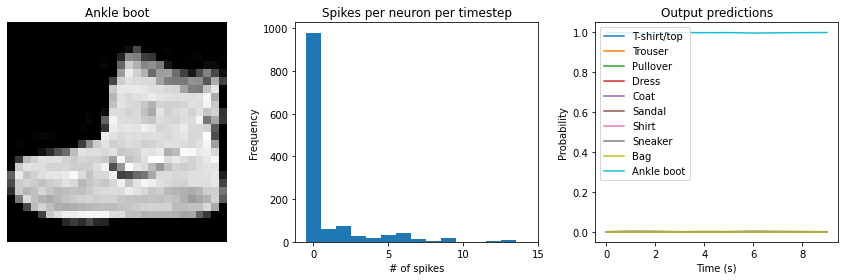

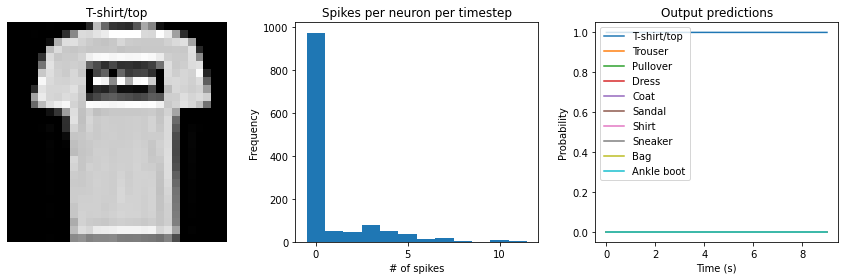

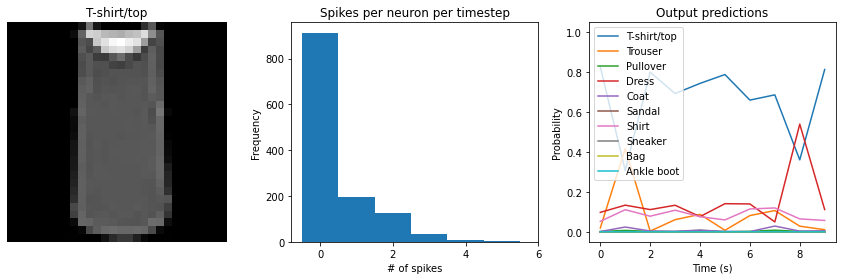

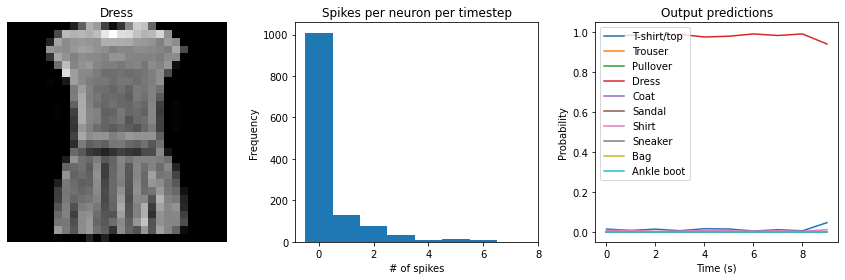

In [10]:
check_output(spiking_model, modify_dt=1)

In [11]:
spikeaware_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

train(spikeaware_model, train_sequences, test_sequences)

Train accuracy (0):  0.6974
Train accuracy (1):  0.78601664
Train accuracy (2):  0.8078667
Train accuracy (3):  0.8205
Train accuracy (4):  0.82695
Train accuracy (5):  0.8336
Train accuracy (6):  0.83996665
Train accuracy (7):  0.84426665
Train accuracy (8):  0.84596664
Train accuracy (9):  0.84995
Test accuracy: 0.8537


Test accuracy: 85.39%
Spike rate per neuron (Hz): min=0.00 mean=2.69 max=70.00


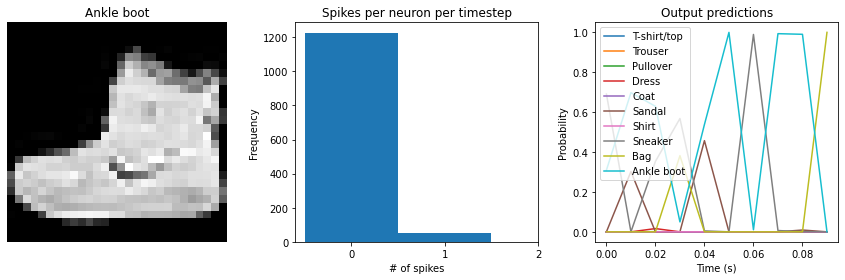

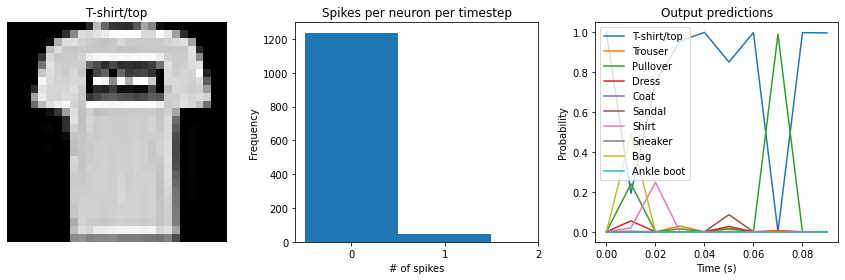

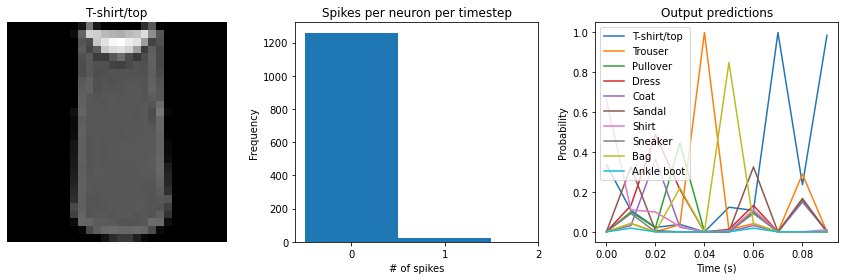

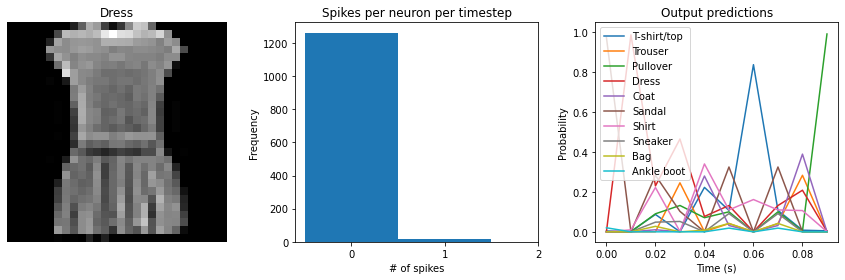

In [12]:
check_output(spikeaware_model)